In [1]:
# utilizado para la manipulación de directorios y rutas
import os

# Cálculo científico y vectorial para python
import numpy as np

import pandas as pd

# Libreria para graficos
from matplotlib import pyplot

# Modulo de optimizacion en scipy
from scipy import optimize

# le dice a matplotlib que incruste gráficos en el cuaderno
%matplotlib inline


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import dask.dataframe as dd

### 1. Se modificó el dataset original

Se duplicó el número de ejemplos de 50.000 a 100.000 ejemplos. También se adicionaron 3 nuevas columnas que son:

- category_char (Columna 3074): Indica si la imagen pertenece a un "vehículo" (V), un "animal" (A), o un "objeto volador" (F).
- category_text (Columna 3075): Proporciona una descripción textual de la clase de cada imagen. Por ejemplo, "avión", "automóvil", etc.
- category_bool (Columna 3076): Indica si la imagen pertenece a un "vehículo" (True) o a un "animal" (False).

In [35]:
# Configuración
# tamaño de la imagen 32 * 32 px * 3 canales de color (RGB)
input_layer_size = 3072
# número de clases
num_labels = 10

# Cargar el dataset original
data = pd.read_csv('train.csv')

# Cargando a X todas las filas y todas las columnas menos la última
X = data.iloc[:, :-1].values
# Cargando a y todas las filas y solo la última columna
y = data.iloc[:, -1].values

# Un diccionario que mapea cada etiqueta numérica (0 a 9)
class_names = {
    0: ('F', 'avión', True),
    1: ('V', 'automóvil', True),
    2: ('F', 'pájaro', False),
    3: ('A', 'gato', False),
    4: ('A', 'ciervo', False),
    5: ('A', 'perro', False),
    6: ('A', 'rana', False),
    7: ('A', 'caballo', False),
    8: ('V', 'barco', True),
    9: ('V', 'camión', True)
}

# Crear nuevas columnas en el DataFrame original basadas en las etiquetas
# map() aplica una función a cada valor de la columna label
# se crea una nueva columna para cada tipo char
data['category_char'] = data['label'].map(lambda x: class_names[x][0])
# se crea una nueva columna para cada tipo text
data['category_text'] = data['label'].map(lambda x: class_names[x][1])
# se crea una nueva columna para cada tipo bool
data['category_bool'] = data['label'].map(lambda x: class_names[x][2])

# Crear dataset sintético con ruido
# saca el numero de ejemplos
num_samples = len(data)
# añadir ruido gaussiano a los datos (0 media, 0.001 desviación estándar)
noise = np.random.normal(0, 0.001, X.shape)
# duplicar los datos originales con ruido
X_duplicated = X + noise


# Crear DataFrame para los datos sintéticos
# crea un DataFrame con los datos duplicados y con los encabezados de las columnas
data_sintetico = pd.DataFrame(X_duplicated, columns=[f'pixel_{i}' for i in range(input_layer_size)])
# añadir las etiquetas a los datos sintéticos
data_sintetico['label'] = y
# añadir las nuevas columnas al DataFrame sintético
data_sintetico['category_char'] = data['category_char']
data_sintetico['category_text'] = data['category_text']
data_sintetico['category_bool'] = data['category_bool']

# Concatenar los datos originales y sintéticos
df_sintetico = pd.concat([data, data_sintetico], ignore_index=True)
df_sintetico.to_csv('dataset_sintetico.csv', index=False)

print(f"El nuevo dataset sintético con {df_sintetico.shape[0]} ejemplos ha sido guardado en 'dataset_sintetico.csv'")

El nuevo dataset sintético con 100000 ejemplos ha sido guardado en 'dataset_sintetico.csv'


### 2. Grafica representativa de los datos del dataset original y sintetico

- Histogramas de Distribución de Características: crea una figura con histogramas que muestran la distribución de valores para algunas      características seleccionadas en dos conjuntos de datos (original y sintético). Cada característica tiene dos gráficos, uno para cada conjunto de datos, lo que permite comparar visualmente cómo se distribuyen los valores en los dos conjuntos. Esto puede ayudarte a entender cómo el añadido de ruido afecta la distribución de los datos.

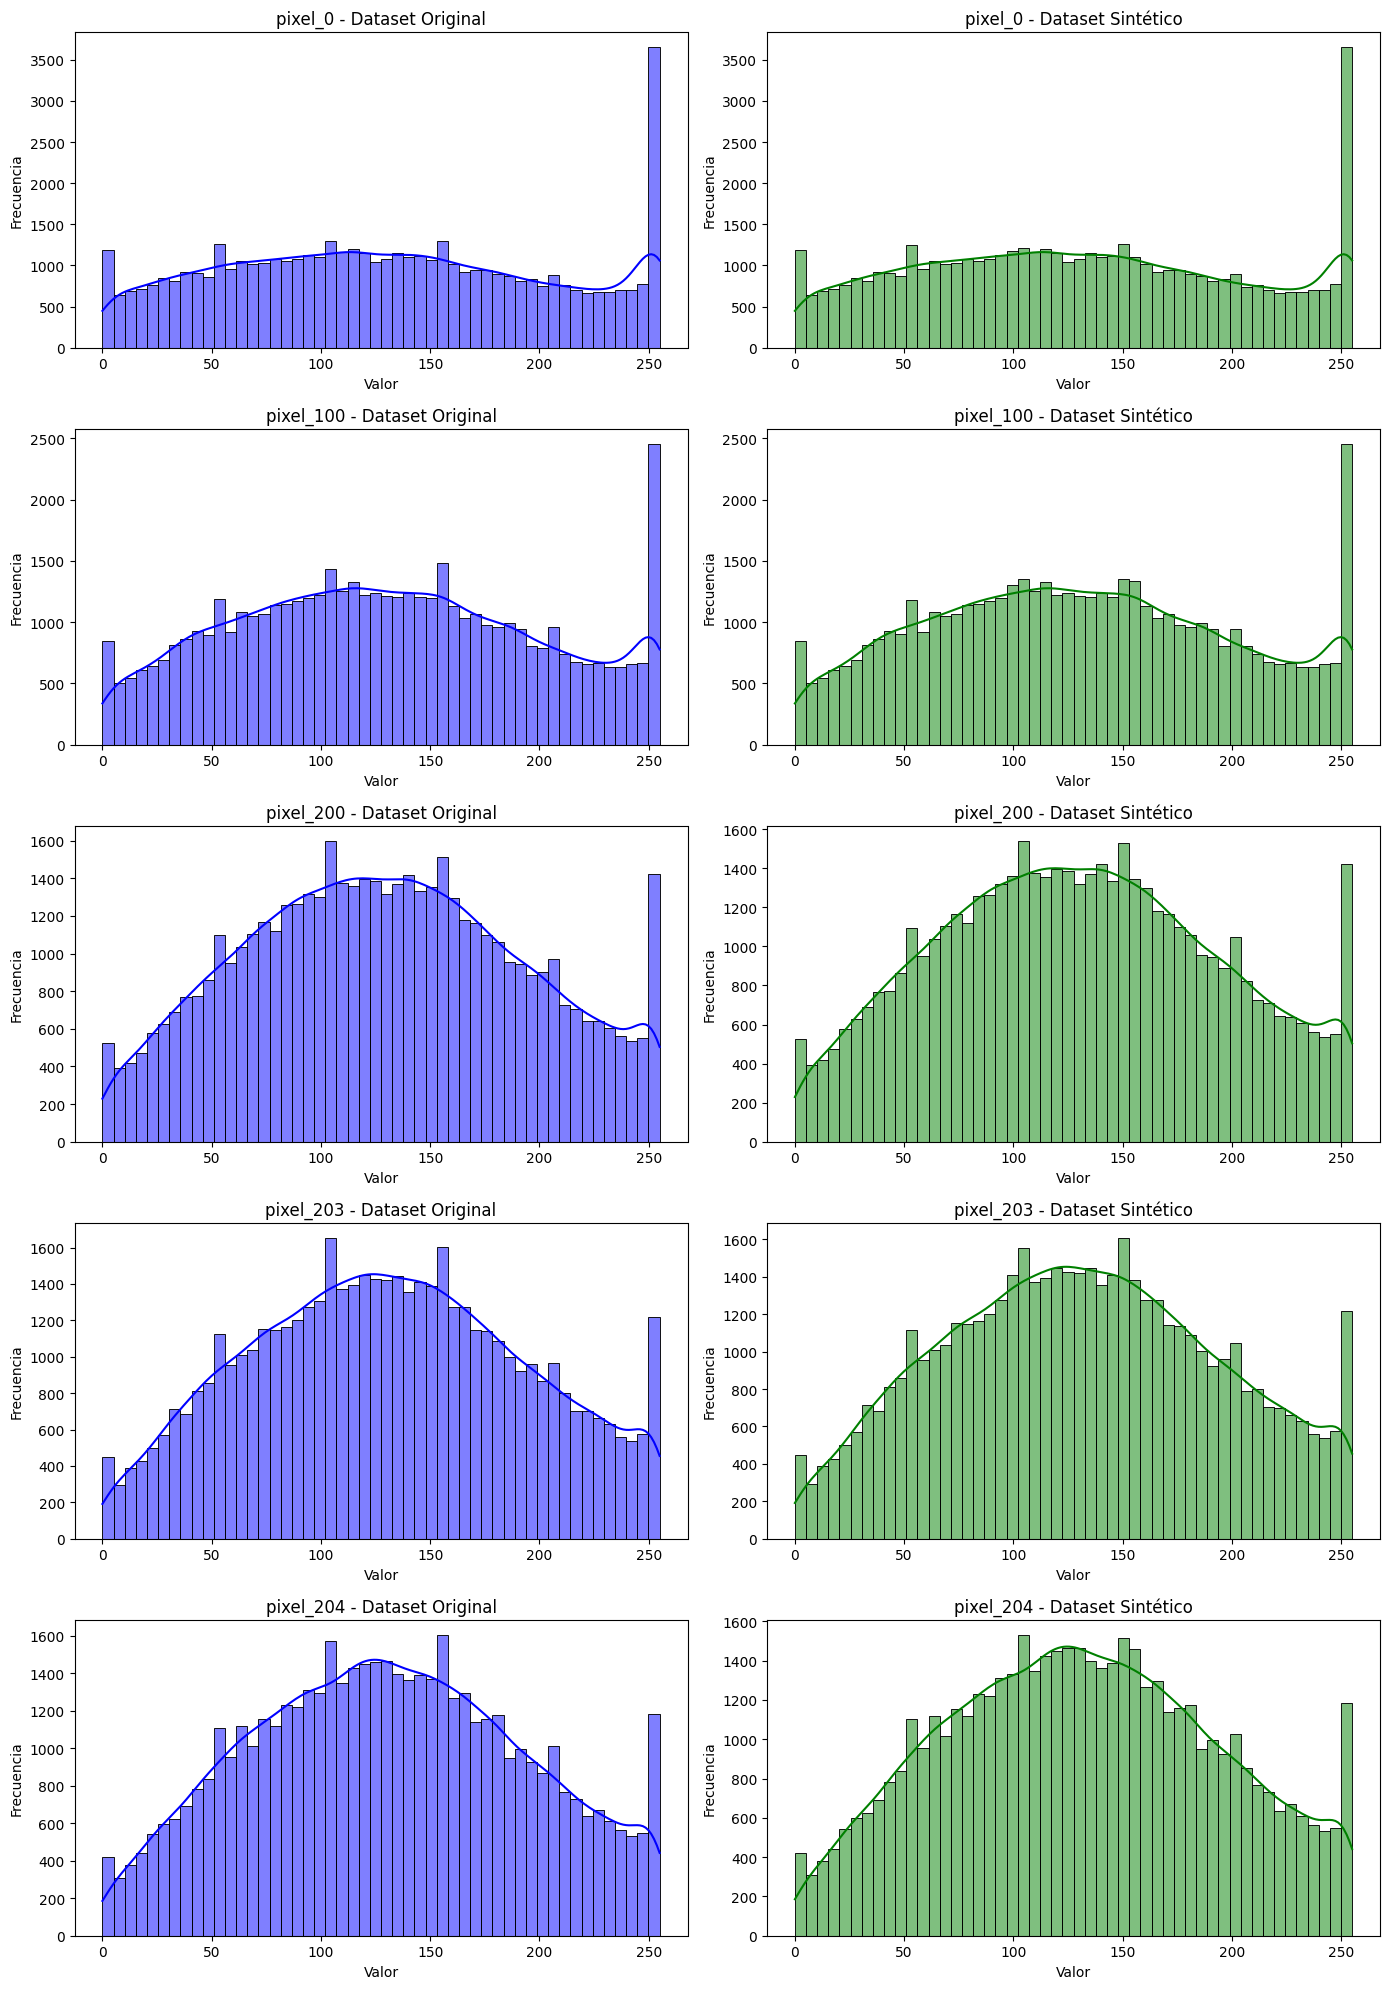

In [36]:
# Definir una muestra de características para visualizar
sample_features = ['pixel_0', 'pixel_100', 'pixel_200', 'pixel_203', 'pixel_204']  

# Crear una figura con dos subgráficos por característica
fig, axes = pyplot.subplots(nrows=len(sample_features), ncols=2, figsize=(14, len(sample_features) * 4))

# Graficar histogramas para cada característica en el dataset original y sintético
for i, feature in enumerate(sample_features):
    # Histograma para el dataset original
    sns.histplot(data[feature], bins=50, kde=True, ax=axes[i, 0], color='blue')
    axes[i, 0].set_title(f'{feature} - Dataset Original')
    axes[i, 0].set_xlabel('Valor')
    axes[i, 0].set_ylabel('Frecuencia')
    
    # Histograma para el dataset sintético
    sns.histplot(data_sintetico[feature], bins=50, kde=True, ax=axes[i, 1], color='green')
    axes[i, 1].set_title(f'{feature} - Dataset Sintético')
    axes[i, 1].set_xlabel('Valor')
    axes[i, 1].set_ylabel('Frecuencia')

# Ajustar el espaciado entre los gráficos
pyplot.tight_layout()
pyplot.show()


Gráficos de Dispersión: crea dos gráficos de dispersión que muestran la relación entre dos características específicas (pixel_0 y pixel_1) en dos conjuntos de datos diferentes: el dataset original y el dataset sintético. Esto permite comparar visualmente cómo se distribuyen las características seleccionadas en ambos conjuntos de datos y observar el efecto del ruido añadido en el dataset sintético.

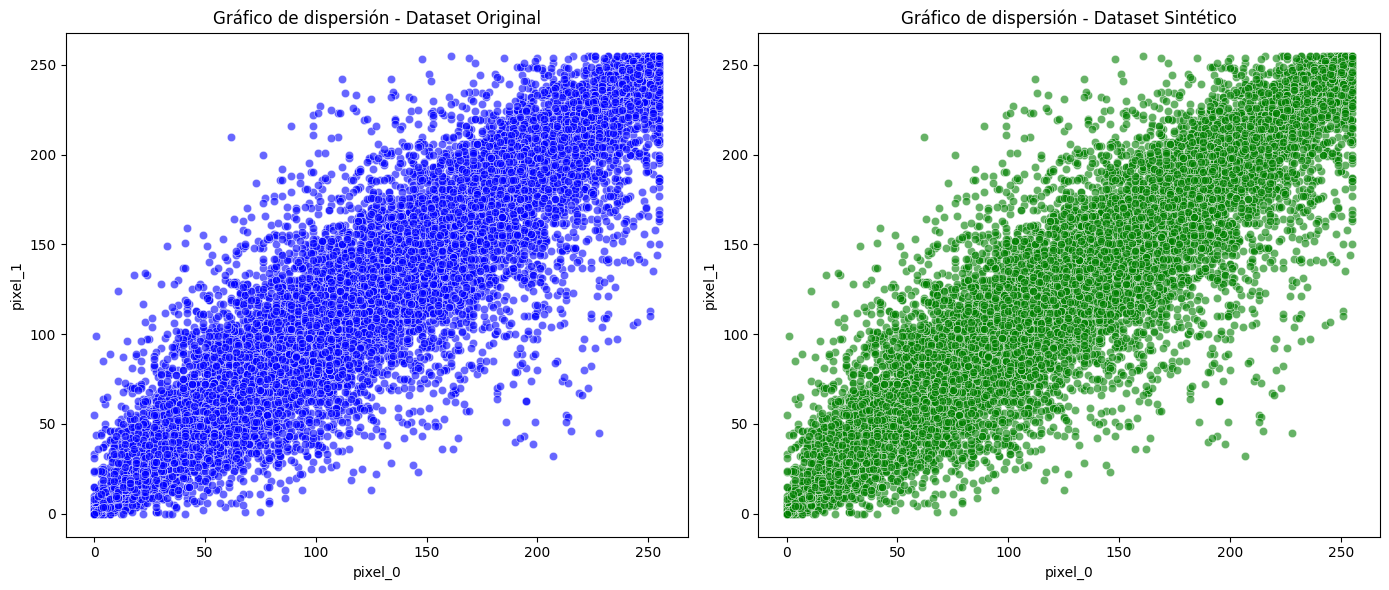

In [37]:
# Definir dos características para graficar
feature_x = 'pixel_0'
feature_y = 'pixel_1'

# Crear una figura con dos subgráficos
fig, axes = pyplot.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Gráfico de dispersión para el dataset original
sns.scatterplot(x=data[feature_x], y=data[feature_y], ax=axes[0], color='blue', alpha=0.6)
axes[0].set_title('Gráfico de dispersión - Dataset Original')
axes[0].set_xlabel(feature_x)
axes[0].set_ylabel(feature_y)

# Gráfico de dispersión para el dataset sintético
sns.scatterplot(x=data_sintetico[feature_x], y=data_sintetico[feature_y], ax=axes[1], color='green', alpha=0.6)
axes[1].set_title('Gráfico de dispersión - Dataset Sintético')
axes[1].set_xlabel(feature_x)
axes[1].set_ylabel(feature_y)

# Ajustar el espaciado entre los gráficos
pyplot.tight_layout()
pyplot.show()


### 3. Dividir los datos del dataset sintético en datos de entrenamiento y prueba
Dask es una biblioteca para el procesamiento de datos en paralelo y es útil para manejar datasets grandes que no caben en memoria.

In [38]:
# Leer el dataset usando Dask
df = dd.read_csv('dataset_sintetico.csv')

# Convertir el Dask DataFrame a Pandas DataFrame (esto será intensivo en memoria si el dataset es grande)
df_pandas = df.compute()

# Dividir en datos de entrenamiento y prueba (80% entrenamiento, 20% prueba)
# usa la funcion de scikit-learn para dividir los datos
X_train, X_test = train_test_split(
    # Tiene el dataset, el tamaño de la prueba, la semilla y la estratificación
    df_pandas, test_size=0.2, random_state=42, stratify=df_pandas['label']
)

# Guardar los conjuntos de entrenamiento y prueba en archivos CSV
X_train.to_csv('sintetico_train.csv', index=False)
X_test.to_csv('sintetico_test.csv', index=False)

# Imprimir el tamaño de cada conjunto
print(f"Conjunto de entrenamiento: {X_train.shape[0]} ejemplos, {X_train.shape[1]} columnas")
print(f"Conjunto de prueba: {X_test.shape[0]} ejemplos, {X_test.shape[1]} columnas")

Conjunto de entrenamiento: 80000 ejemplos, 3076 columnas
Conjunto de prueba: 20000 ejemplos, 3076 columnas


### 4. modelo de regresión logística binaria por separado de cada clase

Chunks se utilizan para manejar datos grandes de manera más eficiente. Cuando un archivo de datos es demasiado grande para ser cargado en la memoria RAM en su totalidad, puedes leerlo en fragmentos más pequeños (chunks) que se procesan uno por uno.

Este fracmento hace:

- Leer datos en chunks: Esto permite manejar grandes datasets sin cargar todo en memoria a la vez, lo que es útil para trabajar con datos que pueden ser demasiado grandes para la RAM disponible.

- Definir etiquetas de clase: Este diccionario se usa para traducir las etiquetas numéricas en nombres de clase significativos, facilitando la interpretación de los resultados del modelo.

In [39]:
# Leer el dataset en chunks
chunk_size = 10000
chunks = pd.read_csv('sintetico_train.csv', chunksize=chunk_size)

# Etiquetas para las clases
class_labels = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

Aqui de saca la sigmoide(función de activación)

La hipotesis para la regresión logistica se define como:

$$ h_\theta(x) = g(\theta^T x)$$

donde la función $g$ is la función sigmoidea. La función sigmoidea se define como:

$$g(z) = \frac{1}{1+e^{-z}}$$


In [40]:
# Función sigmoide
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

La funcion de costo(binary cross entropy) en una regresión logistica es:

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m} \left[ -y^{(i)} \log\left(h_\theta\left( x^{(i)} \right) \right) - \left( 1 - y^{(i)}\right) \log \left( 1 - h_\theta\left( x^{(i)} \right) \right) \right]$$

y el gradiente del costo es un vector de la misma longitud como $\theta$ donde el elemento $j^{th}$ (para $j = 0, 1, \cdots , n$) se define como:

$$ \frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)} $$

Si bien este gradiente parece idéntico al gradiente de regresión lineal, la fórmula es diferente porque la regresión lineal y logística tienen diferentes definiciones de $h_\theta(x)$.
<a id="costFunction"></a>

- Gradiente: Ayuda a encontrar la dirección en la que la función de costo disminuye más rápidamente.
- Uso: Es utilizado por el algoritmo de optimización para ajustar los parámetros del modelo y minimizar el costo, mejorando así el rendimiento del modelo en los datos de entrenamiento.

In [41]:
# Función de costo con regularización
def calcularCosto(theta, X, y, lambda_):
    m = y.size  # Número de ejemplos
    # Si las etiquetas son booleanas, conviértelas a enteros
    if y.dtype == bool:
        y = y.astype(int)
    # Calculamos la hipótesis
    h = sigmoid(X.dot(theta.T))
    # Aseguramos que los valores de h estén en un rango adecuado para evitar log(0)
    epsilon = 1e-15
    h = np.clip(h, epsilon, 1 - epsilon)
    # Calculamos el término de regularización (exceptuando theta[0])
    temp = theta.copy()
    temp[0] = 0  # No regularizamos el término de sesgo (theta[0])
    # Función de costo con regularización
    J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h))) \
        + (lambda_ / (2 * m)) * np.sum(np.square(temp))
    
    # Gradiente con regularización (no regularizamos theta[0])
    grad = (1 / m) * (X.T.dot(h - y)) + (lambda_ / m) * temp
    return J, grad

Funcion del decenso por el gradiente

El algoritmo de descenso por el gradiente es un método de optimización usado para minimizar una función de costo ajustando iterativamente los parámetros del modelo. En el código proporcionado, se aplica el descenso por el gradiente para encontrar los mejores valores para los parámetros del modelo en un problema de clasificación binaria

- (1 / m) * X.T.dot(h - y): Calcula el gradiente del costo con respecto a los parámetros. X.T.dot(h - y) mide la diferencia entre las predicciones y las etiquetas reales, multiplicado por las características X.
- (lambda_ / m) * np.concatenate([[0], theta[1:]]): Añade la regularización al gradiente. lambda_ / m es el término de regularización, y np.concatenate([[0], theta[1:]]) asegura que el término de sesgo theta[0] no se regularice.

In [42]:
# Descenso por el gradiente
def descensoGradiente(theta, X, y, alpha, num_iters, lambda_):
    m = y.shape[0]
    J_history = []
    for i in range(num_iters):
        h = sigmoid(X.dot(theta))
        gradient = (1 / m) * X.T.dot(h - y) + (lambda_ / m) * np.concatenate([[0], theta[1:]])
        theta -= alpha * gradient
        J, _ = calcularCosto(theta, X, y, lambda_)
        J_history.append(J)
    return theta, J_history

inicializamos parametros y mostramos graficas de costos por clase

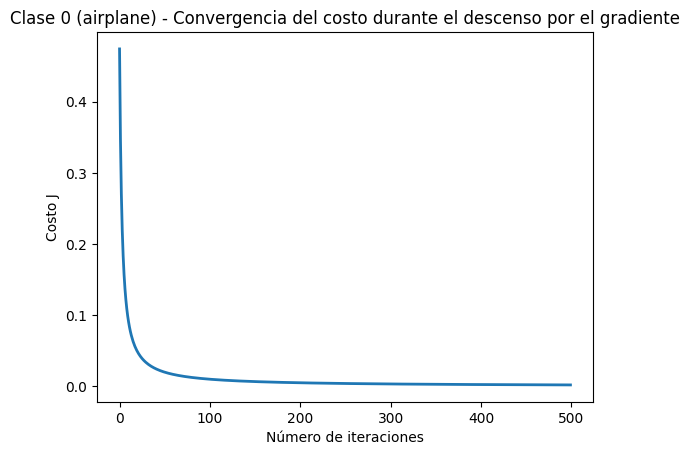

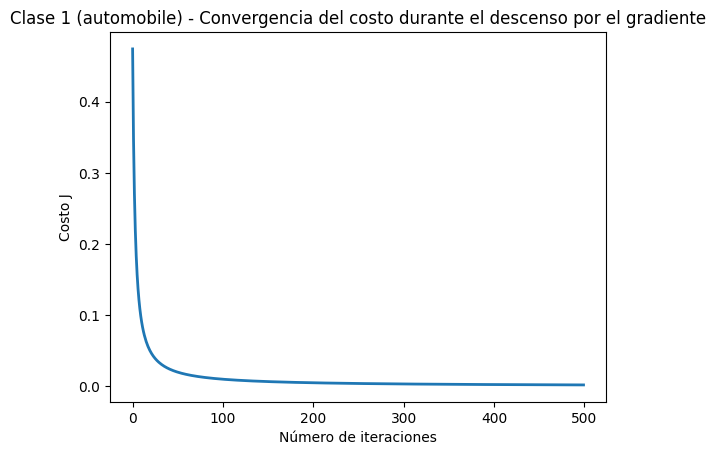

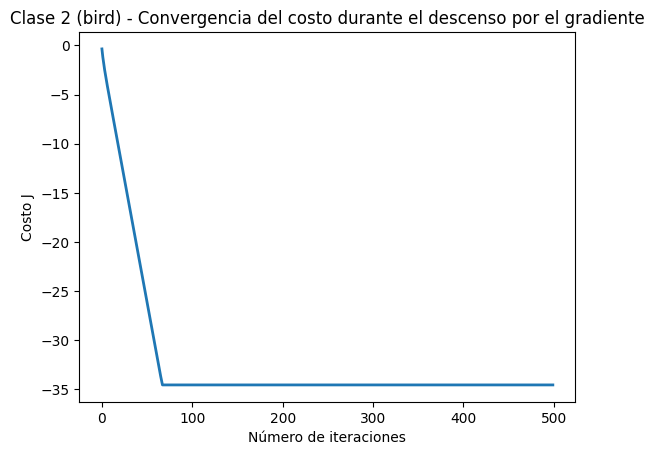

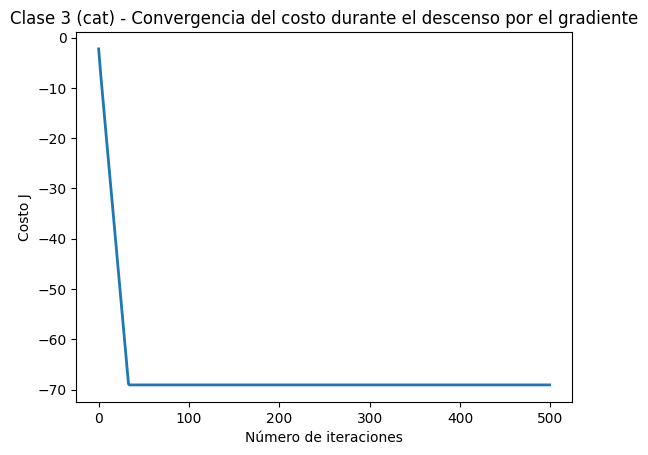

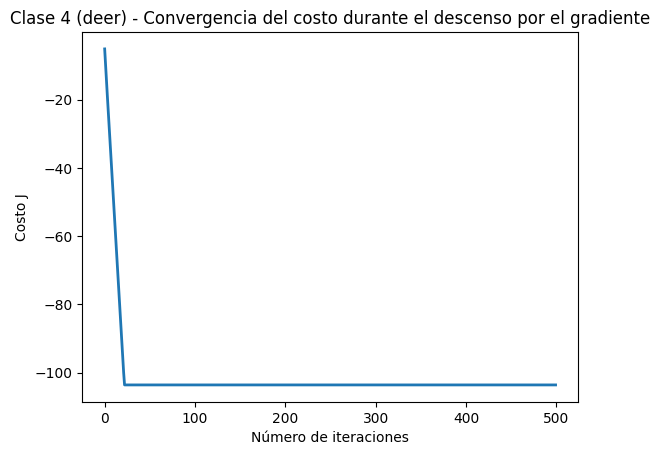

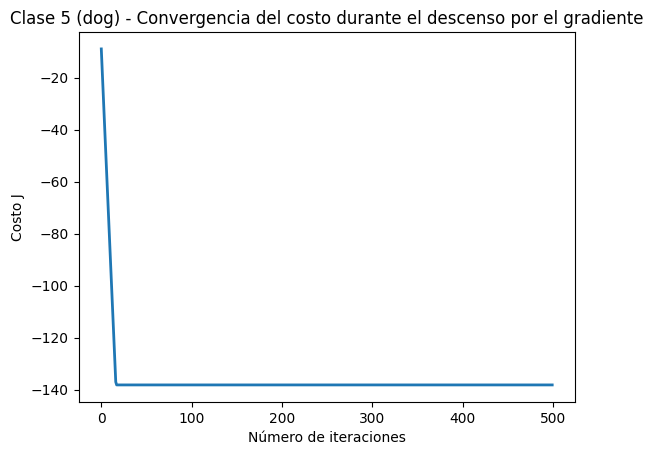

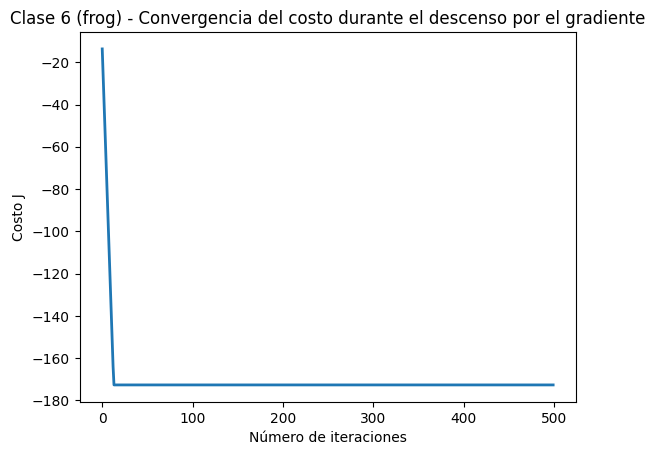

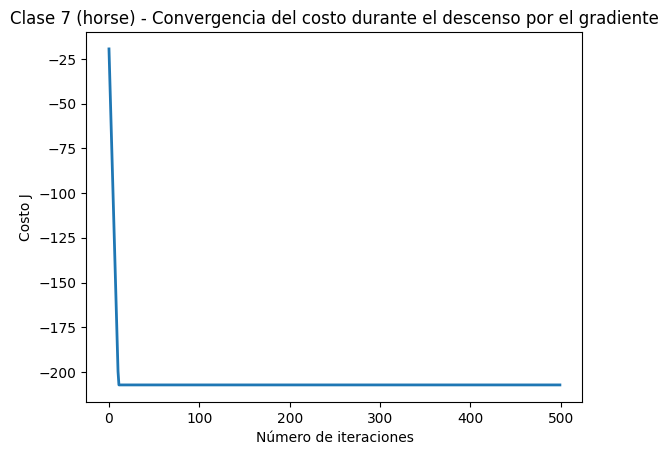

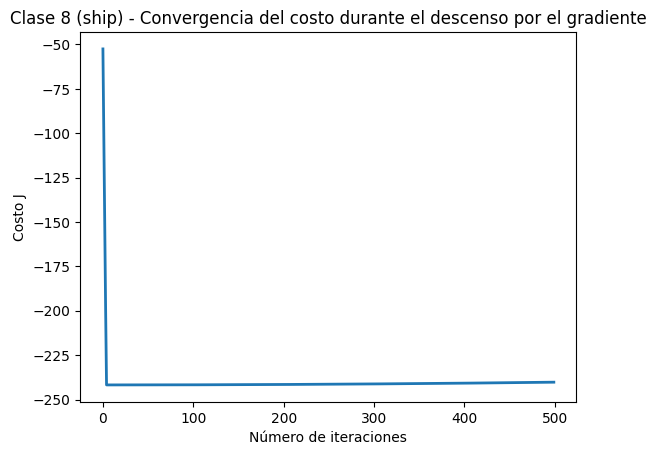

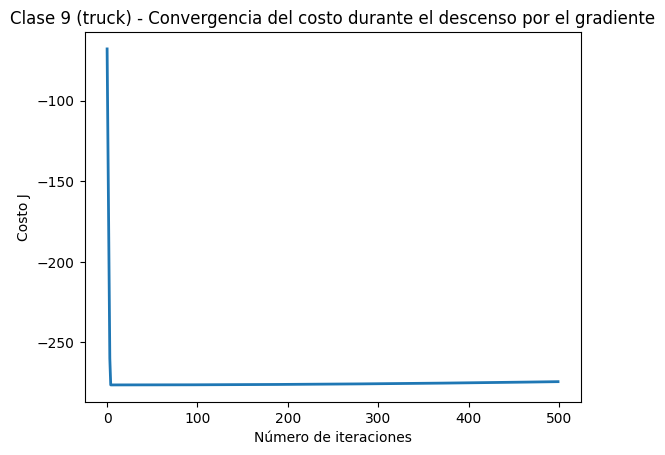

In [43]:
# Inicializa parámetros para el descenso por el gradiente
alpha = 0.5
num_iters = 500
lambda_ = 0.001

# Graficar la función de costo para cada clase
for label, class_name in class_labels.items():
    # Procesar cada chunk
    for chunk in chunks:
        # Convertir los valores booleanos de 'category_bool' a numéricos
        X = chunk['category_bool'].astype(int).values.reshape(-1, 1)  # Convertir True/False a 1/0

        # Filtrar para obtener solo las filas donde 'label' es igual al valor actual
        mask = chunk['label'] == label
        if np.sum(mask) == 0:
            print(f"No hay instancias con la clase {label} ({class_name}) en este chunk.")
            continue

        X = X[mask]
        y = chunk['label'][mask].values

        # Añadir una columna de unos para el término de sesgo
        X = np.hstack((np.ones((X.shape[0], 1)), X))

        # Inicializa theta para el descenso por el gradiente
        initial_theta = np.zeros(X.shape[1])

        # Ejecuta el descenso por el gradiente
        theta, J_history = descensoGradiente(initial_theta, X, y, alpha, num_iters, lambda_)

        # Graficar la convergencia del costo
        pyplot.figure()
        pyplot.plot(np.arange(len(J_history)), J_history, lw=2)
        pyplot.xlabel('Número de iteraciones')
        pyplot.ylabel('Costo J')
        pyplot.title(f'Clase {label} ({class_name}) - Convergencia del costo durante el descenso por el gradiente')
        pyplot.show()

        # Salir del loop de chunks después de procesar la clase
        break

    # Asegúrate de que los chunks se reinicien para la próxima clase
    chunks = pd.read_csv('sintetico_train.csv', chunksize=chunk_size)

### 5. Entrenamiento con modelo One-vs-All

In [2]:
# Ingresar imágenes de dígitos de 20x20
input_layer_size  = 3072

# 10 etiquetas, de 1 a 10 (tomar en cuenta que se asigna "0" a la etiqueta 10)
num_labels = 10

# Leer el archivo CSV usando pandas
df = pd.read_csv('sintetico_train.csv')

# Seleccionar columnas de píxeles (0-3071)
X_pixels = df.iloc[:, :3072].values  # Primeros 3072 datos son los píxeles

# Convertir la columna 'label' en etiquetas (solo para la variable y)
y = df['label'].values

# Convertir 'category_char', 'category_text', y 'category_bool' a valores numéricos
# Crear un mapa de los valores a números
category_char_map = {'F': 0, 'V': 1, 'A': 2}
category_text_map = {'avión': 0, 'automóvil': 1, 'pájaro': 2, 'gato': 3, 'ciervo': 4, 'perro': 5, 'rana': 6, 'caballo': 7, 'barco': 8, 'camión': 9}
category_bool_map = {True: 1, False: 0}

# Convertir las columnas usando los mapas
category_char_numeric = df['category_char'].map(category_char_map).values
category_text_numeric = df['category_text'].map(category_text_map).values
category_bool_numeric = df['category_bool'].map(category_bool_map).values

# Crear una matriz con las características adicionales
X_additional = np.vstack((category_char_numeric, category_text_numeric, category_bool_numeric)).T

# Concatenar las características de píxeles y características adicionales
X = np.hstack((X_pixels, X_additional))

m = y.size

# Verificar la forma de los datos
print(f'Forma de X: {X.shape}')
print(f'Forma de y: {y.shape}')

Forma de X: (80000, 3075)
Forma de y: (80000,)


In [3]:
def displayData(X_pixels, example_width=None, figsize=(10, 10)):
    """
    Muestra datos 2D almacenados en X en una cuadrícula apropiada.
    """
    # Calcula filas, columnas
    if X_pixels.ndim == 2:
        m, n = X_pixels.shape
    elif X_pixels.ndim == 1:
        n = X_pixels.size
        m = 1
        X_pixels = X_pixels[None]  # Promocionar a una matriz bidimensional
    else:
        raise IndexError('La entrada X debe ser 1 o 2 dimensinal.')

    # Ancho de cada imagen
    example_width = example_width or int(np.round(np.sqrt(n // 3)))
    example_height = int(n / (example_width * 3))  # Para imágenes RGB (3 canales)

    # Calcula el número de elementos a mostrar
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))

    fig, ax_array = pyplot.subplots(display_rows, display_cols, figsize=figsize)
    fig.subplots_adjust(wspace=0.025, hspace=0.025)

    ax_array = [ax_array] if m == 1 else ax_array.ravel()

    for i, ax in enumerate(ax_array):
        # Redimensionar cada imagen para mostrarla en formato 32x32 píxeles con 3 canales de color
        img = X_pixels[i].reshape(example_height, example_width, 3, order='F')
        ax.imshow(img.astype(np.uint8), extent=[0, 1, 0, 1])
        ax.axis('off')

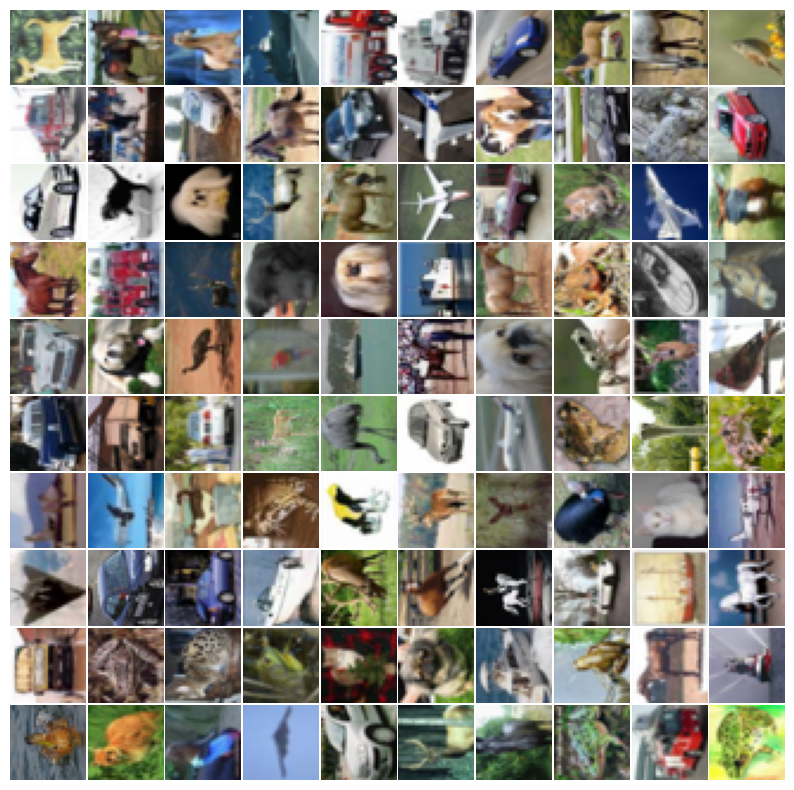

In [4]:
# Selecciona aleatoriamente 100 puntos de datos para mostrar
rand_indices = np.random.choice(m, 100, replace=False)
sel = X_pixels[rand_indices, :]

displayData(sel)

Formula de la normalización:

$$
X_{\text{norm}} = \frac{X - \mu}{\sigma}
$$

- X norm: es la versión normalizada de los datos X,
- 𝜇 : μ es la media de X,
- 𝜎 : σ es la desviación estándar de 𝑋.

In [5]:
# Normalizar las características
def featureNormalize(X):
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0)
    X_norm = (X - mu) / sigma
    return X_norm, mu, sigma

X, mu, sigma = featureNormalize(X)

Se adiciona una columna de unos para todos los ejemplos 

In [6]:
# Añadir una columna de unos para el término de sesgo
X = np.hstack([np.ones((X.shape[0], 1)), X])

Aqui de saca la sigmoide(función de activación)

La hipotesis para la regresión logistica se define como:

$$ h_\theta(x) = g(\theta^T x)$$

donde la función $g$ is la función sigmoidea. La función sigmoidea se define como:

$$g(z) = \frac{1}{1+e^{-z}}$$


In [7]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

Aqui de saca la función de costo:
$$
J(\theta) = \frac{1}{m} \sum_{i=1}^{m} \left[ -y^{(i)} \log\left(h_\theta\left( x^{(i)} \right)\right) - \left(1 - y^{(i)}\right) \log\left( 1 - h_\theta\left( x^{(i)} \right)\right) \right] + \frac{\lambda}{2m} \sum_{j=1}^{n} \theta_j^2
$$

- La fórmula de la función de costo J(θ) se utiliza para medir la precisión del modelo de clasificación.
- El primer término de la suma mide el error entre las predicciones (hₓ(θ)) y los valores reales (y).
- hₓ(θ) es la hipótesis o predicción del modelo calculada usando la función sigmoide.
- El segundo término es el componente de regularización, que agrega λ para penalizar valores altos de los parámetros θ, ayudando a evitar el sobreajuste.
- La regularización no afecta al término de sesgo θ₀.


In [8]:
def lrCostFunction(theta, X, y, lambda_):
    m = y.size
    h = sigmoid(X.dot(theta))
    epsilon = 1e-15
    h = np.clip(h, epsilon, 1 - epsilon)
    
    temp = theta.copy()
    temp[0] = 0  # No regularizamos el término de sesgo (theta[0])
    
    J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h))) \
        + (lambda_ / (2 * m)) * np.sum(np.square(temp))
    
    grad = (1 / m) * (X.T.dot(h - y)) + (lambda_ / m) * temp
    
    return J, grad

Funcion del decenso por el gradiente

In [9]:
def gradientDescent(X, y, theta, alpha, num_iters, lambda_):
    m = y.size  # Número de ejemplos
    J_history = []  # Lista para almacenar los costos en cada iteración
    
    for i in range(num_iters):
        # Calculamos el costo y el gradiente
        J, grad = lrCostFunction(theta, X, y, lambda_)
        
        # Guardamos el costo en J_history
        J_history.append(J)
        
        # Actualizamos los parámetros usando el gradiente descendente
        theta = theta - alpha * grad
    
    return theta, J_history


Función One vs All

In [10]:
def oneVsAll(X, y, num_labels, lambda_, alpha, num_iters):
    m, n = X.shape
    all_theta = np.zeros((num_labels, n))  # Inicializamos theta para cada clase
    J_histories = []  # Lista para almacenar los costos de cada clase
    
    for c in range(num_labels):
        initial_theta = np.zeros(n)
        theta, J_history = gradientDescent(X, (y == c).astype(int), initial_theta, alpha, num_iters, lambda_)
        all_theta[c] = theta
        J_histories.append(J_history)  # Guardamos el historial de costos de esta clase
    
    return all_theta, J_histories


configuracion de parametros y entrenamiento de pesos

In [11]:
# Parámetros de entrenamiento
lambda_ = 1
alpha = 0.01
num_iters = 300
num_labels = 10

# Entrenamiento del clasificador One-vs-All usando gradiente descendente
all_theta, J_histories = oneVsAll(X, y, num_labels, lambda_, alpha, num_iters)

# Predicciones
def predictOneVsAll(all_theta, X):
    m = X.shape[0]
    num_labels = all_theta.shape[0]
    
    p = np.zeros(m)
    
    predictions = sigmoid(X.dot(all_theta.T))
    p = np.argmax(predictions, axis=1)
    
    return p

calculando precisión y mostrando la función de costo

Precisión del conjunto de entrenamiento: 66.73%


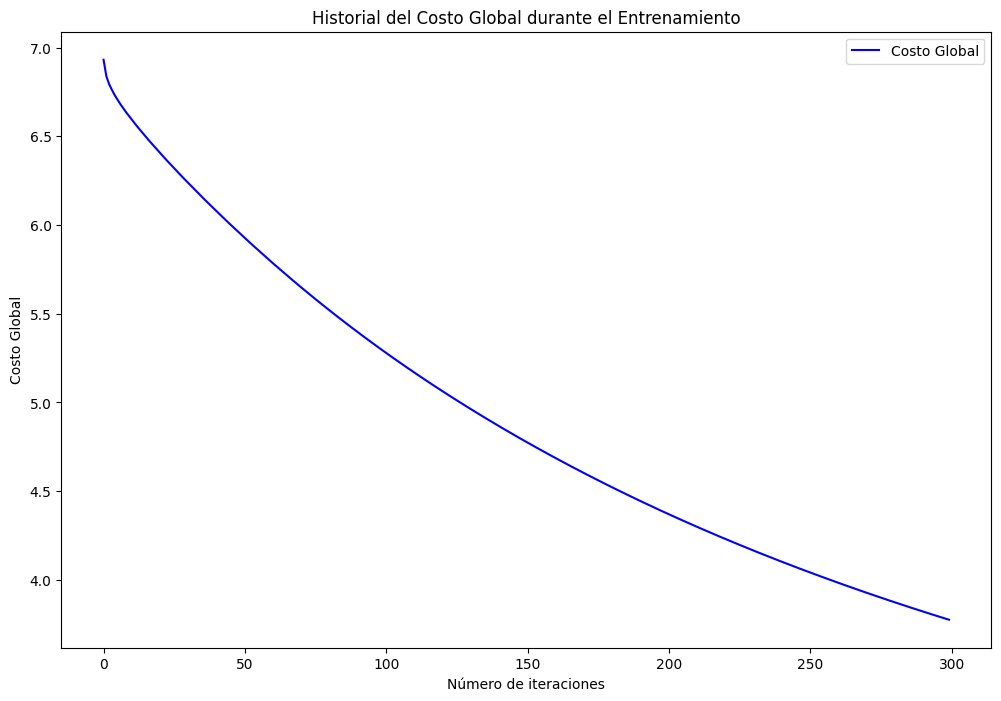

In [12]:
# Calcular la precisión
pred = predictOneVsAll(all_theta, X)
print('Precisión del conjunto de entrenamiento: {:.2f}%'.format(np.mean(pred == y) * 100))

# Calcular el costo global sumando o promediando los costos de todas las clases
J_global = np.sum(J_histories, axis=0)

# Graficar el costo global
pyplot.figure(figsize=(12, 8))
pyplot.plot(J_global, label='Costo Global', color='b')

pyplot.xlabel('Número de iteraciones')
pyplot.ylabel('Costo Global')
pyplot.title('Historial del Costo Global durante el Entrenamiento')
pyplot.legend()
pyplot.show()

### 6. Verificar efectividad con dataset de prueba

In [13]:
# Cargar el dataset de prueba
df_test = pd.read_csv('sintetico_test.csv')

# Seleccionar las columnas de píxeles y las características adicionales como en el conjunto de entrenamiento
X_test_pixels = df_test.iloc[:, :3072].values  # Primeros 3072 valores son píxeles

# Convertir las columnas adicionales de 'category_char', 'category_text', y 'category_bool' a valores numéricos
category_char_numeric_test = df_test['category_char'].map(category_char_map).values
category_text_numeric_test = df_test['category_text'].map(category_text_map).values
category_bool_numeric_test = df_test['category_bool'].map(category_bool_map).values

# Crear una matriz con las características adicionales
X_test_additional = np.vstack((category_char_numeric_test, category_text_numeric_test, category_bool_numeric_test)).T

# Concatenar las características de píxeles y las adicionales
X_test = np.hstack((X_test_pixels, X_test_additional))

# Agregar el término de sesgo (columna de unos) a X_test
X_test = np.concatenate([np.ones((X_test.shape[0], 1)), X_test], axis=1)

In [14]:
# Cargar las etiquetas del conjunto de prueba
y_test = df_test['label'].values

# Hacer predicciones en el conjunto de prueba
pred_test = predictOneVsAll(all_theta, X_test)

# Calcular la precisión en el conjunto de prueba
precision_test = np.mean(pred_test == y_test) * 100

# Imprimir la precisión
print(f'Precisión en el conjunto de prueba: {precision_test:.2f}%')


Precisión en el conjunto de prueba: 22.61%
